# Scénario

Vous êtes consultant Data Analyst dans une entreprise spécialisée dans la data. Votre entreprise a décroché une prestation en régie au sein de l’Organisation nationale de lutte contre le faux-monnayage (ONCFM).

Cette institution a pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros. Ils font donc appel à vous, spécialiste de la data, pour mettre en place une modélisation qui serait capable d’identifier automatiquement les vrais des faux billets. Et ce à partir simplement de certaines dimensions du billet et des éléments qui le composent.

![Food](https://user.oc-static.com/upload/2020/11/25/16063163322759_Screen%20Shot%202020-11-05%20at%2011.15.15.png)

Nous aimerions pouvoir mettre en concurrence deux méthodes de prédiction : 
 - une régression logistique classique ; 
 - un k-means, duquel seront utilisés les centroïdes pour réaliser la prédiction. 
 
Cet algorithme se devra d’être naturellement le plus performant possible pour identifier un maximum de faux billets au sein de la masse de billets                           
analysés chaque jour.

### SOMMAIRE

* [Partie 1 : Analyse des données](#chapter1)
    * [Valeurs manquantes](#section_1_1)
    * [Imputation ](#chapter2)
    * [Forme de la distribution des variables](#section_1_2)
    * [Corrélations](#section_1_3)
    * [Analyse des valeurs aberrantes](#section_1_4)
        * [margin_low](#section_1_4_1)
        * [length](#section_1_4_2)
    * [Analyse en Composantes Principales](#section_1_5)
* [Partie 2 : Modèles prédictif ](#chapter3)
    * [Méthode des K-means](#section3_2)
         * [Prédiction sur les données TEST](#section3_2_1)
    * [Régression Logistique](#section3_1)
         * [Prédiction sur les données TEST](#section3_1_1)

## Importation des librairies

In [568]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels 
from functions import *

## Charger et voir les données 

In [483]:
url = 'D:\\Downloads\\billets.csv'
df_1 = pd.read_csv(url,  encoding = "utf-8",sep=";")
df_billet=df_1.copy()

# Données TEST
url = 'D:\\Downloads\\billets_production.csv'
df_1 = pd.read_csv(url,  encoding = "utf-8",sep=",")
df_billet_test=df_1.copy()

# **Partie 1 : Analyse de la forme des données** <a class="anchor" id="chapter1"></a>

### 1- Données des dimensions des billets

In [33]:
df_billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [189]:
df_billet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


On constate les valeurs manquantes mentionnées par un de mes collègues, elles sont dans la colonne **margin_low**

In [489]:
df_billet["is_genuine"] = df_billet["is_genuine"].astype("int")

In [553]:
df_billet_group = df_billet.groupby(by="is_genuine").mean()

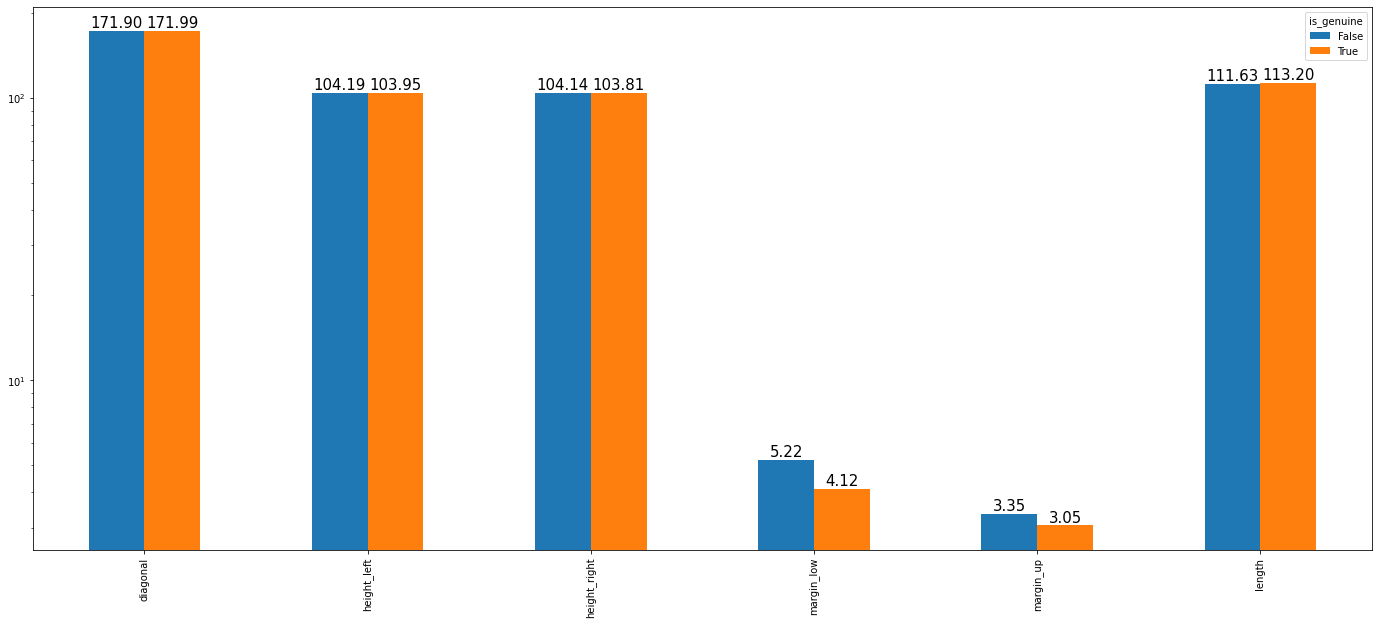

In [102]:

plots = df_billet_group.T.plot.bar(figsize=(24,10), logy=True)
# Iterrating over the bars one-by-one
for bar in plots.patches:
   
 plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

margin_low et length ont une plus grande différence entre les vrais et les faux billets comparé aux autres variables. Jetons un coup d'oeil

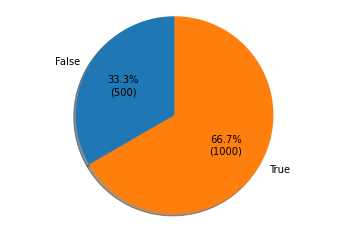

In [126]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["False","True"]
sizes = [df_billet["is_genuine"][df_billet["is_genuine"] == False].count(),
       df_billet["is_genuine"][df_billet["is_genuine"] == True].count()]
explode = (  0.0, 0.0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()

def func(pct, allvals):
    absolute = float(round(pct/100.*np.sum(allvals) ,2) )
    return "{:.1f}%\n({:.0f})".format(pct, absolute)
ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda pct: func(pct, df_billet["is_genuine"].count()),
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Comptons les valeurs Manquantes <a class="anchor" id="section_1_1"></a>

In [10]:
df_billet_null = df_billet[df_billet.margin_low.isnull()]
print(f"\n{df_billet_null.shape}\n")
df_billet_null.info()
df_billet_null.head()


(37, 7)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 72 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    37 non-null     int32  
 1   diagonal      37 non-null     float64
 2   height_left   37 non-null     float64
 3   height_right  37 non-null     float64
 4   margin_low    0 non-null      float64
 5   margin_up     37 non-null     float64
 6   length        37 non-null     float64
dtypes: float64(6), int32(1)
memory usage: 2.2 KB


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,1,171.94,103.89,103.45,NaN,3.25,112.79
99,1,171.93,104.07,104.18,NaN,3.14,113.08
151,1,172.07,103.80,104.38,NaN,3.02,112.93
197,1,171.45,103.66,103.80,NaN,3.62,113.27
241,1,171.83,104.14,104.06,NaN,3.02,112.36


# **Imputation**  <a class="anchor" id="chapter2"></a>

## **Régression linéaire pour imputer les valeurs manquantes de margin_low** 

Coupons nos données en 2 : 
 - en données d'entraînement 
 - en données de test 
 
Pour que notre modèle soit viable.

In [484]:
from sklearn.model_selection import train_test_split
data = df_billet[df_billet.margin_low.notnull()].drop("margin_low",axis=1)
target = df_billet.margin_low[df_billet["margin_low"].notnull()]
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.8, random_state =42)

Visualisons les prédictions de margin_low comparé aux valeurs réelles.

Text(0, 0.5, 'margin_low')

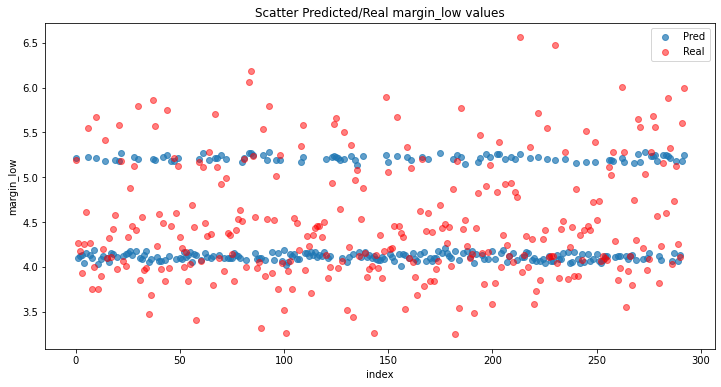

In [208]:
from sklearn.linear_model import LinearRegression # OLS algorithm
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred_lr = reg.predict(X_test)
overview_y_pred = y_pred_lr
overview_y_test = y_test

overview = pd.DataFrame(data=np.column_stack((overview_y_pred,overview_y_test)),
                        columns=['Predictions','Valeurs Réelles'])
fig, axs = plt.subplots(1, figsize=(12, 6))
axs.scatter(overview["Predictions"].index,overview["Predictions"],alpha=0.7)
axs.scatter(overview["Valeurs Réelles"].index,overview["Valeurs Réelles"],c="red",alpha=0.5)
plt.legend(["Pred","Real"])
plt.title("Scatter Predicted/Real margin_low values")
plt.xlabel("index")
plt.ylabel("margin_low")

In [485]:
df_marg_null = df_billet[df_billet["margin_low"].isnull()]

Prédictions des valeurs manquantes de margin_low

In [486]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred_lr = reg.predict(df_marg_null.drop("margin_low",axis=1))
y_pred_lr

array([4.06938428, 4.10336446, 4.13031141, 3.99396239, 4.12760733,
       4.11389167, 4.07633805, 4.12446936, 4.09906978, 4.08873428,
       4.11992572, 4.17994822, 4.13193146, 4.05745458, 4.18089595,
       4.21229457, 4.11371814, 4.10752426, 4.08102494, 4.10067529,
       4.11570853, 4.13623525, 4.14985075, 4.10660784, 4.12431372,
       4.2008434 , 4.11700616, 4.0824432 , 4.12732375, 5.23959025,
       5.24191591, 5.2705044 , 5.29280389, 5.19827169, 5.16033803,
       5.17695942, 5.2344648 ])

Imputations des valeurs manquantes grâce à la régression linéaire

In [487]:
df_billet.margin_low[df_billet["margin_low"].isnull()] = y_pred_lr

<ipython-input-487-3e578cae191b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_billet.margin_low[df_billet["margin_low"].isnull()] = y_pred_lr


### Voyons la distribution de ces variables <a class="anchor" id="section_1_2"></a>

D:\Users\asus\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
D:\Users\asus\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
D:\Users\asus\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
D:\Users\asus\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


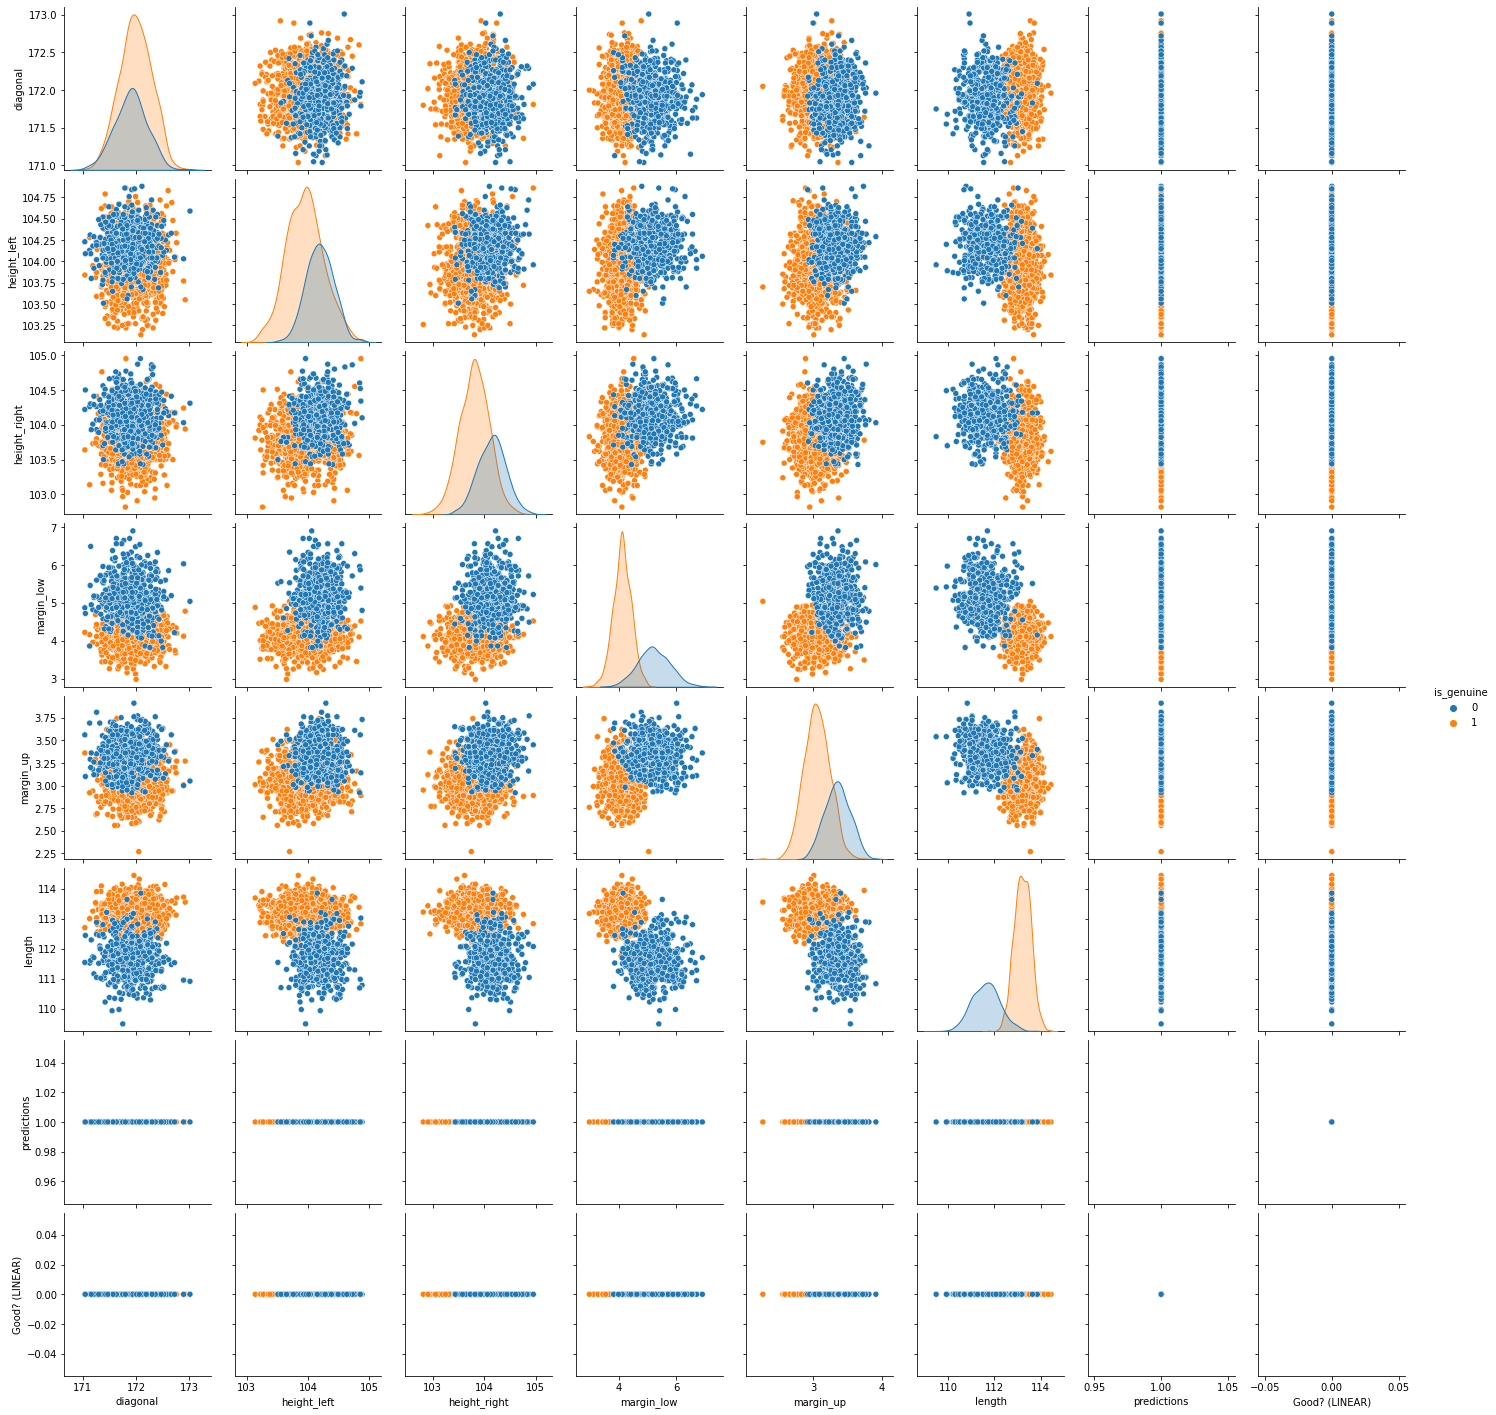

In [99]:
sns.pairplot(df_billet, hue="is_genuine");

### Et maintenant leur corrélation <a class="anchor" id="section_1_3"></a>

<ipython-input-344-85e1b3320276>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


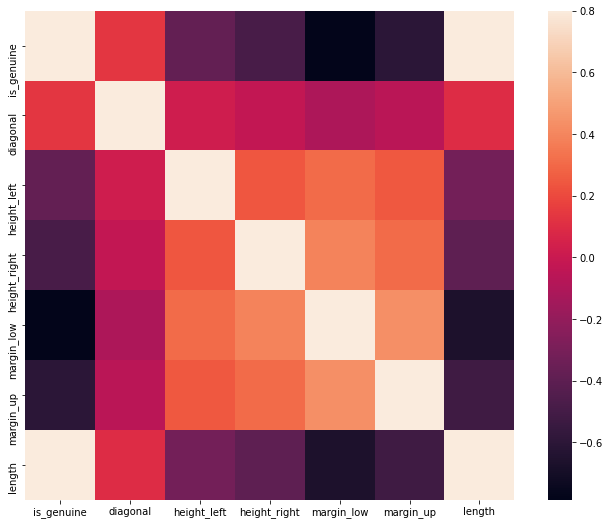

In [344]:
plt, ax = plt.subplots(figsize=(12,9))
sns.heatmap(df_billet[["is_genuine"]+["diagonal"] +["height_left"] +["height_right"]+ ["margin_low"] +["margin_up"] +["length"]].corr(),vmax= .8, square=True)
plt.show()

On remarque une corrélation positive entre is_genuine et length donc plus le billet est long plus il y a de chance que cela soit un vrai.

Et une corrélation négative entre is_genuine et margin_low donc plus margin_low est petit plus il y a de chance que cela soit un vrai.

Cela correspond à nos hypothèses.

### Analyse des valeurs aberrantes <a class="anchor" id="section_1_4"></a>

#### Commençons par margin_low <a class="anchor" id="section_1_4_1"></a>

{'whiskers': [<matplotlib.lines.Line2D at 0x277562bfa90>,
 'caps': [<matplotlib.lines.Line2D at 0x277562bf220>,
 'boxes': [<matplotlib.lines.Line2D at 0x277562bf070>],
 'medians': [<matplotlib.lines.Line2D at 0x27754989f70>],
 'fliers': [<matplotlib.lines.Line2D at 0x277549893a0>],
 'means': []}

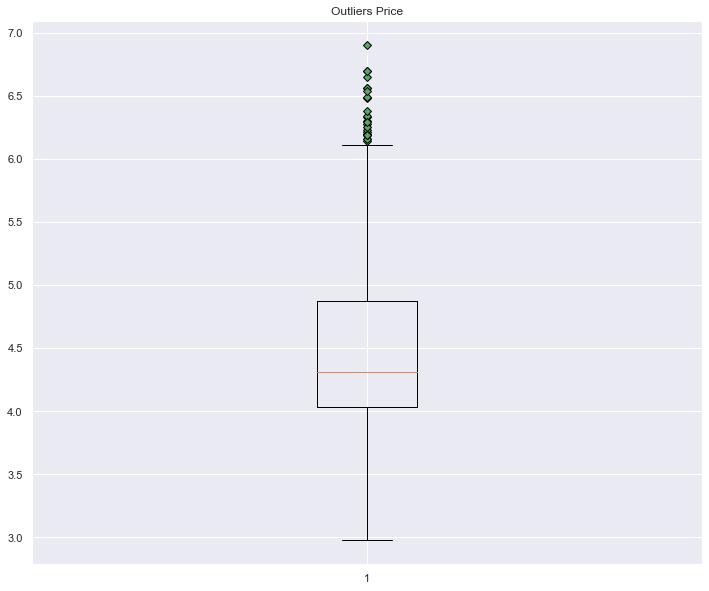

In [485]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig3, ax3 = plt.subplots(1, figsize=(12, 10))
ax3.set_title('Outliers Price')
ax3.boxplot(df_billet["margin_low"], flierprops=green_diamond)


In [366]:
# Prix moyen
mean = np.mean(df_billet["margin_low"])
# Ecart type du prix
std = np.std(df_billet["margin_low"])
print('La moyenne de margin_low  est : ', round(mean,2))
print("L'écart type de margin_low  est : ", round(std,2))

La moyenne de margin_low  est :  4.48
L'écart type de margin_low  est :  0.66


In [367]:
threshold = 1.5
outlier = []
nb=0
for i in df_billet["margin_low"]:
    z = (i-mean)/std
    if z > threshold:
        nb+=1
        outlier.append(i)
print(f"\nUn Z-Score supérieur à 1.5 révèle un outlier.\nIl y a {nb} valeurs aberrantes.")



Un Z-Score supérieur à 1.5 révèle un outlier.
Il y a 160 valeurs aberrantes.


In [10]:
df_billet_only_out = df_billet[df_billet['margin_low'].isin(outlier)].sort_values(by= "margin_low", ascending=False)

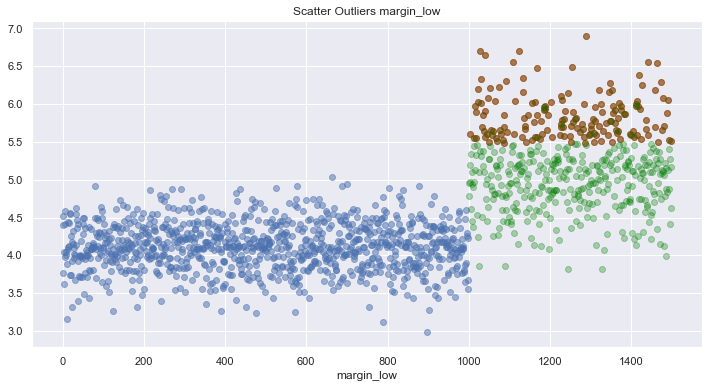

In [504]:
fig, axs = plt.subplots(1, figsize=(12, 6))

axs.scatter(df_billet[df_billet.is_genuine==1]["margin_low"].index, "margin_low",  alpha=0.5, data= df_billet[df_billet.is_genuine==1])
axs.scatter(df_billet_only_out["margin_low"].index, "margin_low" ,alpha=0.5,c= "red",data=df_billet_only_out)

axs.scatter(df_billet[df_billet.is_genuine==0]["margin_low"].index, "margin_low" ,alpha=0.3,c= "green",data=df_billet[df_billet.is_genuine==0])

plt.title("Scatter Outliers margin_low")
plt.xlabel("margin_low")
plt.show()

On constate que les valeurs aberrantes (en rouge) appartiennent aux faux billets (en vert), cette variable nous aidera pour le modèle prédictif. On remarque également que les valeurs au dessus de 5 n'appartiennent à aucun vrai billet.

#### Passons à la variable **length** <a class="anchor" id="section_1_4_2"></a>

{'whiskers': [<matplotlib.lines.Line2D at 0x277538d2460>,
 'caps': [<matplotlib.lines.Line2D at 0x277538d2f40>,
 'boxes': [<matplotlib.lines.Line2D at 0x277538d2eb0>],
 'medians': [<matplotlib.lines.Line2D at 0x27754f534f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x27754f53be0>],
 'means': []}

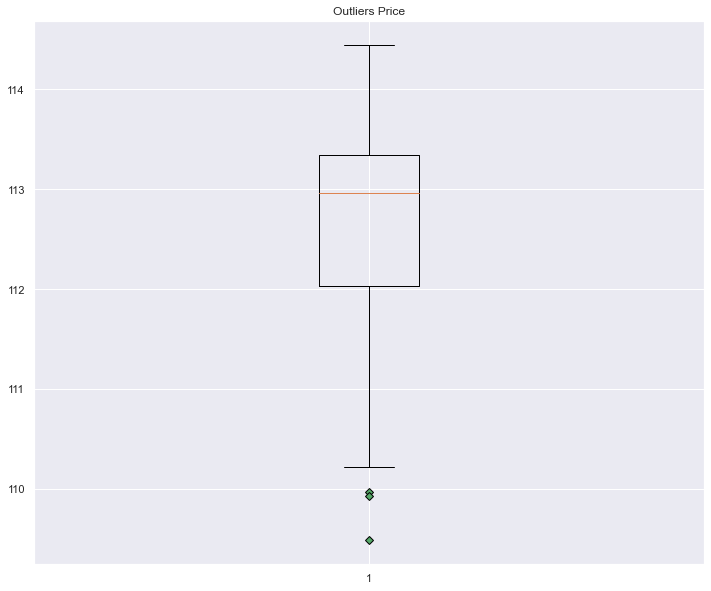

In [486]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig3, ax3 = plt.subplots(1, figsize=(12, 10))
ax3.set_title('Outliers Price')
ax3.boxplot(df_billet["length"], flierprops=green_diamond)

In [346]:
# length moyen
mean = np.mean(df_billet["length"])
# Ecart type  length
std = np.std(df_billet["length"])
print('La moyenne de length  est : ', round(mean,2))
print("L'écart type de length  est : ", round(std,2))

La moyenne de length  est :  112.68
L'écart type de length  est :  0.87


In [347]:
threshold = 1.5
outlier = []
nb=0
for i in df_billet["length"]:
    z = (i-mean)/std
    if z > threshold:
        nb+=1
        outlier.append(i)
print(f"\nUn Z-Score supérieur à 1.5 révèle un outlier.\nIl y a {nb} valeurs aberrantes.")
print('Les valeurs aberrantes dans price sont : ', outlier)


Un Z-Score supérieur à 1.5 révèle un outlier.
Il y a 15 valeurs aberrantes.
Les valeurs aberrantes dans price sont :  [114.09, 114.04, 114.13, 114.04, 114.03, 114.08, 114.0, 114.14, 114.03, 113.99, 114.07, 113.99, 114.44, 114.15, 114.32]


In [348]:
df_billet_only_out = df_billet[df_billet['length'].isin(outlier)].sort_values(by= "length", ascending=False)

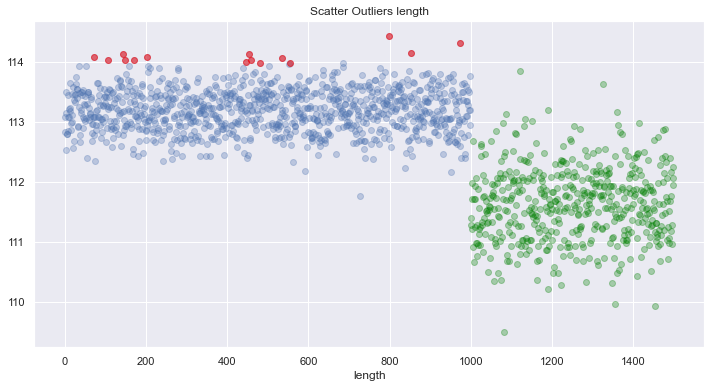

In [509]:
fig, axs = plt.subplots(1, figsize=(12, 6))

axs.scatter(df_billet[df_billet.is_genuine==1]["length"].index, "length",  alpha=0.3, data= df_billet[df_billet.is_genuine==1])
axs.scatter(df_billet_only_out["length"].index, "length" ,c= "red",alpha=0.5,data=df_billet_only_out)

axs.scatter(df_billet[df_billet.is_genuine==0]["length"].index, "length" ,c= "green",alpha=0.3,data=df_billet[df_billet.is_genuine==0])

plt.title("Scatter Outliers length")
plt.xlabel("length")
plt.show()

On constate que les valeurs aberrantes de la variable **length** appartiennent aux vrais billets. Pour améliorer le modèle prédictif, nous ne pouvons supprimer ces valeurs car nous avons peu de données

In [512]:
df_billet[df_billet['length'].isin(outlier)]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,predictions,lengthGroup,Good ? (LOGIT),Good? (LINEAR)
73,1,171.35,103.58,103.59,4.08,2.85,114.09,1.0,>112,True,True
106,1,172.27,103.95,103.75,3.94,3.19,114.04,1.0,>112,True,True
143,1,172.04,103.82,103.79,4.07,3.20,114.13,1.0,>112,True,True
149,1,171.91,103.97,103.60,4.66,3.03,114.04,1.0,>112,True,True
170,1,171.62,104.41,103.71,4.13,3.21,114.03,1.0,>112,True,True
203,1,172.33,104.18,104.04,4.29,2.99,114.08,1.0,>112,True,True
447,1,171.59,103.86,104.33,4.12,2.84,114.00,1.0,>112,True,True
453,1,172.54,104.05,103.78,4.34,2.93,114.14,1.0,>112,True,True
458,1,172.00,104.07,103.55,3.86,3.30,114.03,1.0,>112,True,True
481,1,171.81,103.53,103.96,4.11,2.71,113.99,1.0,>112,True,True


### **Analyse des Composantes principales afin de comprendre les groupes , les liens entre les variables et entre les individus** <a class="anchor" id="section_1_5"></a>

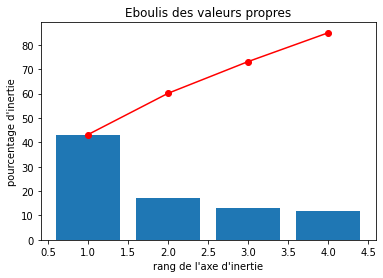

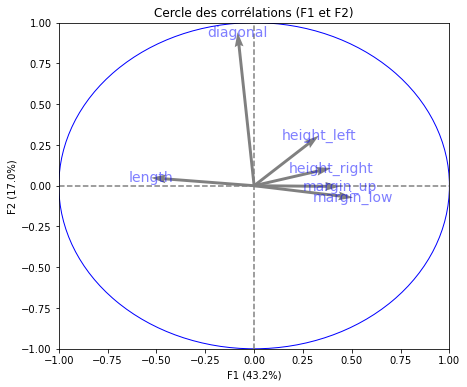

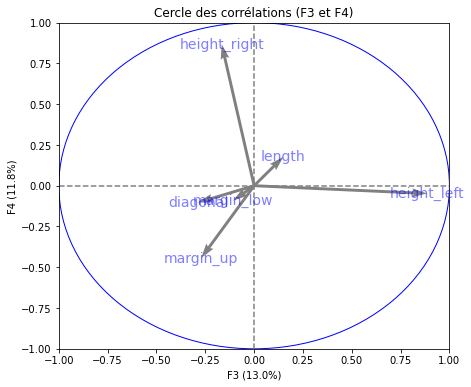

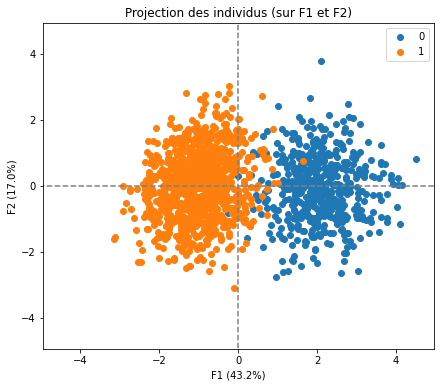

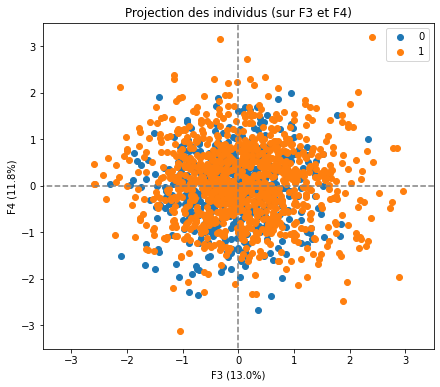

In [167]:
from sklearn import decomposition
from sklearn import preprocessing
from functionsACP import *

# choix du nombre de composantes à calculer
n_comp = 4


# selection des colonnes à prendre en compte dans l'ACP
data_pca = df_billet[[ "diagonal" ,"height_left" ,"height_right" ,"margin_low" ,"margin_up" ,"length" ]]

# préparation des données pour l'ACP

X = data_pca.values
names = df_billet["is_genuine"] # ou data.index pour avoir les intitulés
features = [ "diagonal" ,"height_left" ,"height_right" ,"margin_low" ,"margin_up" ,"length" ]

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)],illustrative_var=names )

plt.show()

Selon le cercle des corrélations , les vrais billets ont une longueur plus élevée que les faux et un margin_low plus bas.

# **Partie 3 : Modèles Prédictif**  <a class="anchor" id="chapter3"></a>

# **1) Méthode K-Means**  <a class="anchor" id="section3_2"></a>

### Choisir K : le nombre de clusters avec la méthode du Coude

In [173]:
distortions = []
K = range(1,6)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_billet.drop("lengthGroup",axis=1).values)
    distortions.append(kmeanModel.inertia_)

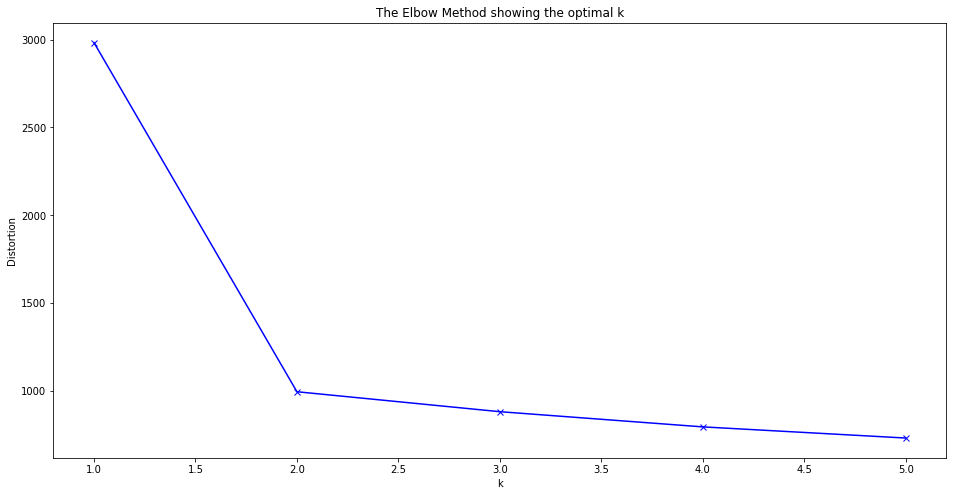

In [174]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

On constate que le nombre de cluster idéal est 2. Lançons le modèle

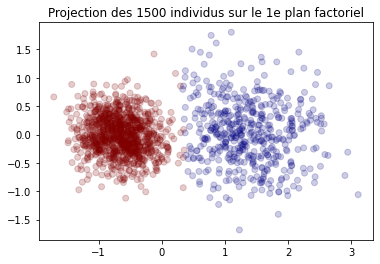

In [476]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import decomposition

# Nombre de clusters souhaités
n_clust = 2

# préparation des données pour le clustering
X = df_billet.drop(["is_genuine"],axis=1).values

# Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
#X_scaled = preprocessing.StandardScaler().fit_transform(X)

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=2).fit(X)
X_projected = pca.transform(X)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

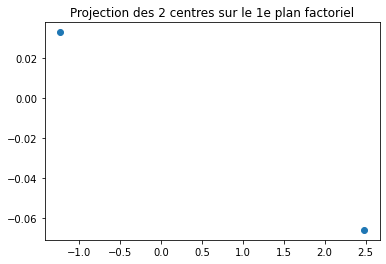

In [419]:
# Affichage des positions des centres de classes
plt.figure()
centroids = km.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

Prédictions par la méthode des K-Means

In [490]:
pred = km.predict(df_billet.drop(["is_genuine"],axis=1).values)

In [491]:
accuracy=[]
best_threshold= []
good_predict= []
wrong_predict=[]



df_billet['Good ? (Kmeans)']= pred == df_billet['is_genuine']
false_predict= df_billet['Good ? (Kmeans)'][df_billet['Good ? (Kmeans)']==False].count()
true_predict=df_billet['Good ? (Kmeans)'][df_billet['Good ? (Kmeans)']==True].count()
accuracy =round(true_predict/df_billet['is_genuine'].shape[0]*100,2)



print(f'Taux de Réussite : {accuracy} % ')
print(f'Bonnes prédictions: {true_predict}')
print(f'Mauvaises prédictions: {false_predict}')  

Taux de Réussite : 98.6 % 
Bonnes prédictions: 1479
Mauvaises prédictions: 21


L'indice de Rand ajusté permet d'évaluer la concordance de deux partitions du jeu de données

In [479]:
from sklearn import metrics
metrics.adjusted_rand_score(pred, km.labels_)

1.0

Cet index ajusté est proche de 0 pour un clustering aléatoire et égal à 1 uniquement quand le clustering correspond exactement à la partition initiale.

Utilsons la matrice de confusion pour évaluer le modèle.

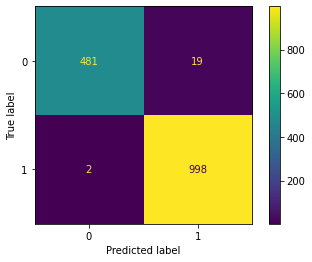

In [480]:
cm = confusion_matrix(df_billet['is_genuine'], pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cm_display.plot()

On remarque qu'il y a 998 vrais positifs, 19 faux positifs et 481 vrais négatifs, 2 faux négatifs.

## TEST avec le modèle des K-Means  <a class="anchor" id="section3_2_1"></a>

In [492]:
a_prevoir = df_billet_test.drop(['id'],axis=1).values
pred_log = km.predict(a_prevoir)

df_billet_test["predictions_K"] = pred_log
df_billet_test

,diagonal,height_left,height_right,margin_low,margin_up,length,id,predictions_K
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1


## **2) Régression logistique pour prédire si un billet est vrai ou non**  <a class="anchor" id="section3_1"></a>

Coupons nos données en 2 : 
 - en données d'entraînement 
 - en données de test 
 
Pour que notre modèle soit viable. Mais cette fois-ci pour prédire **is_genuine** ( 0 = faux billet , 1 = vrai billet)

In [505]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

data = df_billet.drop(["is_genuine","Good ? (Kmeans)","Good ? (LOGIT)"],axis=1)
target = df_billet.is_genuine
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.8, random_state =42)

Lançons le modèle de régression logistique pour prédire si les billets sont faux ou non .

In [587]:
from sklearn import linear_model

#instanciation du modèle
modele_regLog = linear_model.LogisticRegression(random_state = 42,
solver = 'liblinear', multi_class = 'auto')

#training
modele_regLog.fit(X_train,y_train)

#précision du modèle grâce à la validation croisée
cross_val_score(modele_regLog, X_train, y_train ).mean() * 100


99.0

In [500]:
pred_logit = modele_regLog.predict(df_billet.drop(["is_genuine","Good ? (Kmeans)"],axis=1))

df_billet['Good ? (LOGIT)']=pred_logit == df_billet['is_genuine']
false_predict= df_billet['Good ? (LOGIT)'][df_billet['Good ? (LOGIT)']==False].count()
true_predict=df_billet['Good ? (LOGIT)'][df_billet['Good ? (LOGIT)']==True].count()
accuracy =round(true_predict/df_billet['is_genuine'].shape[0]*100,2)


print(f'Taux de Réussite : {accuracy} % ')
print(f'Bonnes prédictions: {true_predict}')
print(f'Mauvaises prédictions: {false_predict}')    




Taux de Réussite : 99.0 % 
Bonnes prédictions: 1486
Mauvaises prédictions: 14


Regardons les mauvaises prédictions

In [237]:
df_billet[df_billet['Good ? (LOGIT)']==False]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,predictions,Good ? (LOGIT)
0,1,171.81,104.86,104.95,4.52,2.89,112.83,0,False
591,1,171.67,103.81,103.76,4.59,3.30,112.18,0,False
669,1,172.14,104.34,104.20,4.63,3.02,112.47,0,False
728,1,171.94,104.11,104.16,4.08,3.35,111.76,0,False
1025,0,172.17,104.20,104.13,3.86,3.38,112.44,1,False
1073,0,172.13,103.67,103.82,4.27,3.22,112.15,1,False
1083,0,171.85,103.60,103.82,4.60,3.21,112.50,1,False
1103,0,171.88,104.05,103.75,4.41,3.21,112.52,1,False
1122,0,172.09,104.15,104.17,4.15,3.40,113.85,1,False
1160,0,172.39,104.05,104.32,4.13,3.41,112.66,1,False


La plupart des erreurs sont des faux billets. La raison de ces mauvaises prédictions provient des valeurs élevées de length et les basses valeurs de margin_low qui sont supposées indiquer la véracité du billet. 

Or ici ce sont des faux billets. Pour améliorer le modèle il faudrait soit utiliser une autre méthode soit intégrer d'autres variables significatives.

Utilsons la courbe ROC pour évaluer le modèle.

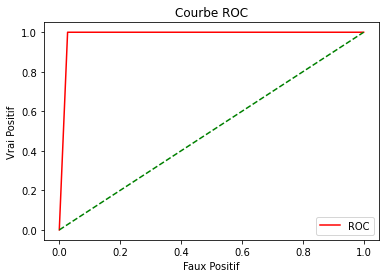

In [313]:
from sklearn.metrics import roc_curve
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('Faux Positif')
    plt.ylabel('Vrai Positif')
    plt.title('Courbe ROC')
    plt.legend()
    plt.show()
pred_test = modele_regLog.predict(X_test)
fper, tper, thresholds = roc_curve(y_test,pred_test)
plot_roc_curve(fper, tper)

À (0, 1) le classificateur n’a aucun faux positif ni aucun faux négatif, et est par conséquent parfaitement exact, ne se trompant jamais. 

Ici, il est proche de la perfection.

Regardons de plus près avec la matrice de confusion

In [243]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_billet['is_genuine'], df_billet['predictions'])

In [244]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

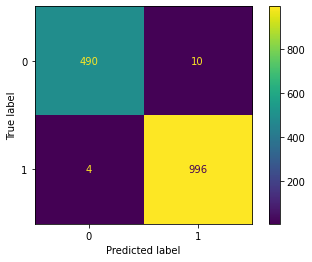

In [245]:
cm_display.plot()

On remarque qu'il y a 996 vrais positifs, 10 faux positifs et 490 vrais négatifs, 4 faux négatifs.

La régression logistique (99.0%) a une meilleure précision que la méthode des K-means (98.6%) .

## TEST avec le modèle de Régression Logistique  <a class="anchor" id="section3_1_1"></a>

In [501]:
# Données TEST
url = 'D:\\Downloads\\billets_production.csv'
df_1 = pd.read_csv(url,  encoding = "utf-8",sep=",")
df_billet_test=df_1.copy()

a_prevoir = df_billet_test.drop(['id'],axis=1)
pred_log = modele_regLog.predict(a_prevoir)

df_billet_test["predictions"] = pred_log
df_billet_test.to_csv(r'D:\\Downloads\\billets_test.csv', index = False)
df_billet_test

,diagonal,height_left,height_right,margin_low,margin_up,length,id,predictions
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1
